## Vlasov equations

We want to solve Vlasov equations on 1  (in $S^1$).

The equations are: 

\begin{align}
\partial_t f + p \partial_x f &= -q E \partial_p f \\
\partial_t E = - J \\
\partial_x E = \rho \\
\end{align}

Where $f = f(t,x,p)$ is a distribution function in phase espace. 
Note that the invarian volume element is, 

$$
dP = dp_x/p_0
$$ 

We define, the particle number with respect to an observer with four-velocity $u^a$,

$$
N = \int f(x,p)(-u \cdot p)\; dP
$$ 

Thus, for the observer at rest in the coordinate system $(t,x)$ we get

$$
N = \int f(x,p) p_0 \; dP = \int f(x,p) \; dp_x
$$ 

Otherwise one has the four-vector particle density,

$$
N^a = \int f(x,p) p^a \; dP = \int f(x,p) \frac{p^a}{p_0} \; dp_x
$$

Thus, 

$$
N^x = \int f(x,p) \frac{p_x}{p_0} \; dp_x
$$

Likewise we have the energy-momentum tensor,

$$
T^{ab} = \int p^a p^b f(x,p) dP 
$$

So, 

$$
T^{00} = \int p^0 f(x,p) dp_x = m \int \sqrt{1 + p^2/m^2} dp
$$




\begin{align}
\rho(t,x) &:= q\int f(t,x,p) \; dp - n_0 \\
n_0 &:= q \int \int f(t,x,p) \; dp \; dx / V\\
J(t,x) &:= q \int v f(t,x,p) \; dp, \\
v &:= \frac{\frac{p}{m}}{\sqrt{1 + \frac{p^2}{m^2}}} \\ 
\end{align}

And $E = E(t,x)$ is the electric field.


The equilibrium distribution function is: 

$$
f(\gamma) = \frac{\gamma^2 \beta}{\theta K_2(\frac{1}{\theta})}\; e^{-\frac{\gamma}{\theta}} \;\;\;\; \gamma = \frac{1}{\sqrt{1 - \beta^2}}
$$ 

or

$$
f(p) = \frac{1}{4\pi m^3 c^3 \theta K_2(\frac{1}{\theta})} \; e^{-\frac{\gamma(p)}{\theta}} \;\;\;\;\; \gamma(p) = \sqrt{1 + (\frac{p}{m})^2}
$$

and $K_2$ is the Bessel function of second kind.

Actually in de code we normalize things differently and define:,
    
$$
    f(p) = f_0 e^{\frac{1-\gamma(p)}{\theta}} \;\;\;\;\; \gamma(p) = \sqrt{1 + (\frac{p}{m})^2},
$$

In [1]:
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf

nthreads = 1


In [40]:
plots = false #sacamos los plots
outputs = false #sacamos los outputs procesados
#plots = true

true

In [43]:
include("aux_functions_vlasov.jl")

### Np must be odd!

In [36]:
run_name = "ltd_"

D_order = 4 # order of finite difference OPERATORS

landau = false
two_streams = false
landau = true
#two_streams = true
#const Np = 201 # we take even since we need positive and negative values
#const Lx = 1
#const Lp = 0.5 # para cada lado

if landau
    if false #undamped
        const Lx = 39.738 
        const Nx = 3522
        const n = 2
        run_name = run_name * "landau_undamped"
    elseif false #damped 
        const Lx = 7.455
        const Nx = 930
        const n = 15
        run_name = run_name * "landau_damped"
    else 
        const Lx = 200
        const Nx = 2000
        const n = 2
        run_name = run_name * "landau_try"
    end

    const Np = 401
    const Lp = 1.0
    
    α = 0.001
    k = 2*π*n/Lx
    θ = 0.001
    run_name = run_name * "$(Nx)_$(Np)_alp3_n$(n)_Th3"
elseif two_streams
    const Nx = 500 # usar par para Fourier transform
    const Lx = 10.0
    const Np = 201
    const Lp = 1.0
    run_name = run_name * "two_streams_"
    const n = 1
    k = 2*π*n/Lx
    α = 0.1
    θ = 0.005
    vel = 0.2
    run_name = run_name * "$(Nx)_$(Np)_v_02_n$(n)_o4_Th005"
end

dx = Lx/Nx # periodic boundary conditions
dp = 2*Lp/(Np-1) # Dichlet... or whatever but not periodic

const m = 1
const e =-1
#const q = 1

const κ = 2π/Lx

println("omega = $(1+3*θ*k^2/2)")

grid = Grid(Nx, Np, Lx, true, false, Lp, dx, dp, 4)

par_grid = (Nx, dx, Np, dp)

p = get_p.(1:Np,dp,Np)/m 
v = [p[j]/sqrt(1+p[j]^2) for j ∈ 1:Np];

run_name


omega = 1.0000059217626407


"ltd_landau_try2000_401_alp3_n2_Th3"

In [37]:
#E = zeros(Nx)
#ϕ = zeros(Nx)
ρ = zeros(Nx) #charge density
S = zeros(Nx) #carge current
E_K = zeros(Nx) # kinetic energy
#E_E = zeros(Nx) # Electromagnetic energy
P = zeros(Nx) # Momentum
du = zeros(Nx * (Np+1)); # contains f and E


## Initial data

In [38]:
u = zeros(Nx * (Np+1))

pars = (Nx, dx, Lx, Np, dp, Lp, κ, e)



if landau
    pars_f = (m, θ, α, k)
    u = generate_initial_data!(landau_rel_dist, u, pars_f, pars);
elseif two_streams
    pars_f = (m, θ, α, k, vel)
    u = generate_initial_data!(counter_streams_rel_dist, u, pars_f, pars);
end

if plots

    F = reshape(u[1:Nx*Np],(Nx,Np));

    #plot(F[Nx÷2,:])
    plot_matrix(F)
    png("initial_dist_" * run_name)
end

Q = -1.2620392006473506
n0 = 0.9999999999999994
total charge = -8.260059303211165e-15


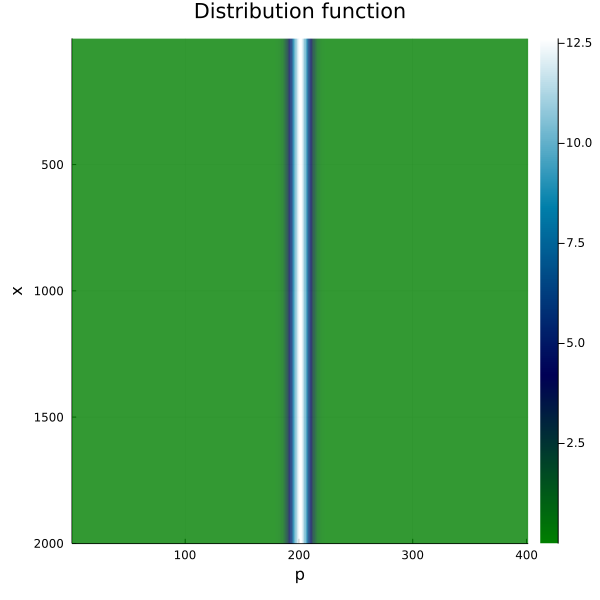

In [32]:
if plots
    heatmap(F,
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        yflip = true,
        xlabel = "p", ylabel = "x",
        title = "Distribution function"
    )

    #png("initial_conf_heat_" * run_name)
end

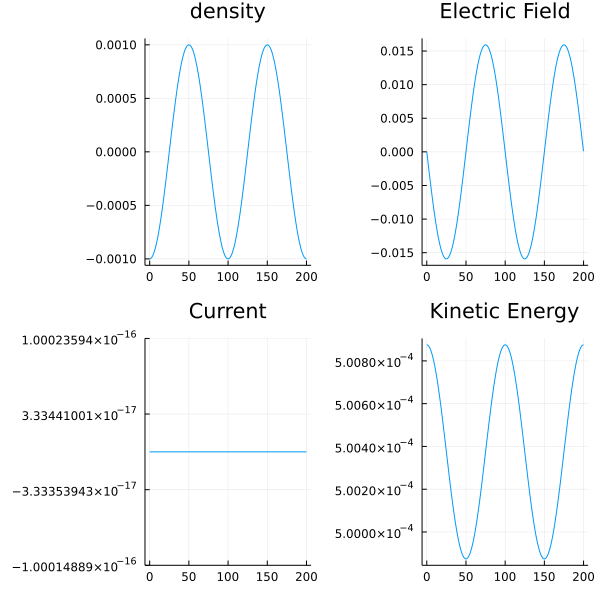

In [44]:
if plots 
    E_i = deepcopy(u[Nx*Np+1:end]) #lo guardamos para compararlo al final
    get_current!(u, S, (Nx, dx, Np, dp, v, m, e));
    get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
    Q = get_total_charge!(ρ,(Nx, dx))
    plot(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))

    x = [(i-1)*dx for i in 1:Nx]

    plot(layout=(2,2))
    plot!(subplot=1,x,ρ .- Q/Lx, title = "density", legend = :false)
    plot!(subplot=2,x,E_i, title = "Electric Field", legend = :false)
    plot!(subplot=3,x,S, title = "Current", legend = :false)
    plot!(subplot=4,x,E_K, title = "Kinetic Energy", legend = :false)

    #png("initial_conf_" * run_name)
end

## Time evolution

In [15]:
t = 0.0
t_i = 0.0
if two_streams
    t_f = 200.0
    M = 20001
    M_g = 500 + 1 #number of outputs, starting from the initial data
end
if landau
    t_f = 20.0
    M = 2001
    M_g = 500 + 1 
end
    
dt = t_f / (M-1)
par_evolv = (t_i, t_f, M, M_g, dt)



(0.0, 20.0, 2001, 501, 0.01)

In [16]:
dvx = zeros(Nx)
dvp = zeros(Np)
k1 = zeros(Nx*(Np+1))
k2 = zeros(Nx*(Np+1))
k3 = zeros(Nx*(Np+1))
k4 = zeros(Nx*(Np+1))
p_F = (dx, dp, Nx, Np, v, S, dvx, dvp, D_order)
par_RK = (k1, k2, k3, k4)

if outputs
    # total quantities 
    Energy_K = zeros(M_g)
    Energy_E = zeros(M_g)
    EField_T = zeros(M_g)
    p_T = zeros(M_g)
    n_T = zeros(M_g)
    S_T = zeros(M_g)
    E_E = 0.0
    #T = zeros(M_g)
end

In [17]:
j = 1

if outputs
    Energy_K[j]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx
    Energy_E[j]  = get_E_energy(u,(Nx, dx, Np, dp))
    EField_T[j] = sum(u[Nx*Np+1:end])*dx
    p_T[j] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))*dx

    get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
    get_current!(u, S, (Nx, dx, Np, dp, v, m, e))
    n_T[j] = get_total_density!(ρ,(Nx, dx))
    S_T[j] = sum(S)/n_T[j]/Nx
    #T[1] = var(u[N+1:2N])
end

In [18]:
run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f)
if outputs
    run_data = Dict()
    run["Energy_E_$j"] = Energy_E[j]
    run["Energy_K_$j"] = Energy_K[j]
    run["E_f$j"] = u[Nx*Np+1:end]
    run["n_F$j"] = ρ
    run["S_F$j"] = S
    run["E_T$j"] = EField_T[j] 
    run["S_T$j"] = S_T[j]
    run["n_T$j"] = n_T[j]
end


file_name = "Results/"* run_name * ".jld2"
#rm(file_name)
j = 1
tiempo = @sprintf("%05d", j)
field_name = "u"

save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

jldopen(file_name, "a+") do file
    file[field_name * "/u_$(tiempo)"] = u;
end


804000-element Vector{Float64}:
 1.623741520461847e-179
 1.623741488442599e-179
 1.623741392386118e-179
 1.6237412322961975e-179
 1.6237410081791565e-179
 1.623740720043843e-179
 1.6237403679016324e-179
 1.623739951766426e-179
 1.6237394716546534e-179
 1.6237389275852674e-179
 1.623738319579747e-179
 1.6237376476620957e-179
 1.6237369118588396e-179
 ⋮
 0.0011988554565212084
 0.0010991172143165473
 0.000999335580846028
 0.0008995144953177769
 0.0007996578984981184
 0.000699769732553368
 0.0005998539408980097
 0.000499914468035656
 0.0003999552594066702
 0.0002999802612291269
 0.0001999934203436582
 9.999868406052048e-5

### Temporal evolution: This takes a while!

In [19]:
#include("aux_functions_vlasov.jl")

for k in 2:M
    RK4_Step!(F!,u,t,dt,p_F,par_RK)
    global t = t + dt
    if (k-1) % (M÷(M_g-1)) == 0
        local j = (k-1)÷(M÷(M_g-1))+1
        if outputs
            Energy_K[j]  = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx
            Energy_E[j]  = get_E_energy(u,(Nx, dx, Np, dp))
            EField_T[j] = sum(u[Nx*Np+1:end])*dx
            p_T[j] = sum(get_momentum!(u,P,(Nx, dx, Np, dp)))*dx
            get_density!(u, ρ, (Nx, dx, Np, dp, m, e))
            get_current!(u, S, (Nx, dx, Np, dp, v, m, e))
            n_T[j] = get_total_density!(ρ,(Nx, dx))
            S_T[j] = sum(S)/n_T[j]/Nx
        end
        
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
        end
        Energy = sum(get_K_energy!(u,E_K,(Nx, dx, Np, dp)))*dx + get_E_energy(u,(Nx, dx, Np, dp))
        println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Energy = $Energy")
        
    end
end

j = 2 , t = 0.04, k = 5, nthreads = 1, Energy = 200.11276024133096
j = 3 , t = 0.08, k = 9, nthreads = 1, Energy = 200.1128212467919
j = 4 , t = 0.11999999999999998, k = 13, nthreads = 1, Energy = 200.11292292466325
j = 5 , t = 0.16, k = 17, nthreads = 1, Energy = 200.1130652781001
j = 6 , t = 0.20000000000000004, k = 21, nthreads = 1, Energy = 200.11324831151933
j = 7 , t = 0.24000000000000007, k = 25, nthreads = 1, Energy = 200.11347203059995
j = 8 , t = 0.2800000000000001, k = 29, nthreads = 1, Energy = 200.11373644228374
j = 9 , t = 0.3200000000000001, k = 33, nthreads = 1, Energy = 200.11404155477462
j = 10 , t = 0.36000000000000015, k = 37, nthreads = 1, Energy = 200.1143873775393
j = 11 , t = 0.4000000000000002, k = 41, nthreads = 1, Energy = 200.11477392130757
j = 12 , t = 0.4400000000000002, k = 45, nthreads = 1, Energy = 200.11520119807247
j = 13 , t = 0.48000000000000026, k = 49, nthreads = 1, Energy = 200.11566922109057
j = 14 , t = 0.5200000000000002, k = 53, nthreads = 1,

j = 126 , t = 4.999999999999938, k = 501, nthreads = 1, Energy = 200.44348442356454
j = 127 , t = 5.039999999999937, k = 505, nthreads = 1, Energy = 200.44901278781154
j = 128 , t = 5.079999999999936, k = 509, nthreads = 1, Energy = 200.45459218616483
j = 129 , t = 5.119999999999935, k = 513, nthreads = 1, Energy = 200.4602227894184
j = 130 , t = 5.159999999999934, k = 517, nthreads = 1, Energy = 200.46590476989545
j = 131 , t = 5.199999999999934, k = 521, nthreads = 1, Energy = 200.47163830145263
j = 132 , t = 5.239999999999933, k = 525, nthreads = 1, Energy = 200.4774235594841
j = 133 , t = 5.279999999999932, k = 529, nthreads = 1, Energy = 200.48326072092618
j = 134 , t = 5.319999999999931, k = 533, nthreads = 1, Energy = 200.48914996426137
j = 135 , t = 5.35999999999993, k = 537, nthreads = 1, Energy = 200.49509146952292
j = 136 , t = 5.399999999999929, k = 541, nthreads = 1, Energy = 200.50108541829908
j = 137 , t = 5.4399999999999284, k = 545, nthreads = 1, Energy = 200.507131993

j = 249 , t = 9.919999999999833, k = 993, nthreads = 1, Energy = 201.57300721620186
j = 250 , t = 9.959999999999832, k = 997, nthreads = 1, Energy = 201.5866026164188
j = 251 , t = 9.999999999999831, k = 1001, nthreads = 1, Energy = 201.60028311296406
j = 252 , t = 10.03999999999983, k = 1005, nthreads = 1, Energy = 201.61404910639502
j = 253 , t = 10.07999999999983, k = 1009, nthreads = 1, Energy = 201.62790099956038
j = 254 , t = 10.119999999999829, k = 1013, nthreads = 1, Energy = 201.64183919760802
j = 255 , t = 10.159999999999828, k = 1017, nthreads = 1, Energy = 201.65586410799327
j = 256 , t = 10.199999999999827, k = 1021, nthreads = 1, Energy = 201.6699761404865
j = 257 , t = 10.239999999999826, k = 1025, nthreads = 1, Energy = 201.6841757071817
j = 258 , t = 10.279999999999825, k = 1029, nthreads = 1, Energy = 201.6984632225043
j = 259 , t = 10.319999999999824, k = 1033, nthreads = 1, Energy = 201.71283910321927
j = 260 , t = 10.359999999999824, k = 1037, nthreads = 1, Energy 

j = 369 , t = 14.71999999999973, k = 1473, nthreads = 1, Energy = 203.9449562864594
j = 370 , t = 14.75999999999973, k = 1477, nthreads = 1, Energy = 203.9723361397757
j = 371 , t = 14.799999999999729, k = 1481, nthreads = 1, Energy = 203.99986791280838
j = 372 , t = 14.839999999999728, k = 1485, nthreads = 1, Energy = 204.02755234276685
j = 373 , t = 14.879999999999727, k = 1489, nthreads = 1, Energy = 204.05539017020254
j = 374 , t = 14.919999999999726, k = 1493, nthreads = 1, Energy = 204.08338213901766
j = 375 , t = 14.959999999999726, k = 1497, nthreads = 1, Energy = 204.1115289964736
j = 376 , t = 14.999999999999725, k = 1501, nthreads = 1, Energy = 204.13983149319955
j = 377 , t = 15.039999999999724, k = 1505, nthreads = 1, Energy = 204.16829038320085
j = 378 , t = 15.079999999999723, k = 1509, nthreads = 1, Energy = 204.19690642386772
j = 379 , t = 15.119999999999722, k = 1513, nthreads = 1, Energy = 204.2256803759832
j = 380 , t = 15.159999999999721, k = 1517, nthreads = 1, En

j = 490 , t = 19.560000000000258, k = 1957, nthreads = 1, Energy = 208.6031107139404
j = 491 , t = 19.600000000000264, k = 1961, nthreads = 1, Energy = 208.65525245018014
j = 492 , t = 19.64000000000027, k = 1965, nthreads = 1, Energy = 208.70766168023948
j = 493 , t = 19.680000000000277, k = 1969, nthreads = 1, Energy = 208.7603395943631
j = 494 , t = 19.720000000000283, k = 1973, nthreads = 1, Energy = 208.81328738677325
j = 495 , t = 19.76000000000029, k = 1977, nthreads = 1, Energy = 208.86650625566887
j = 496 , t = 19.800000000000296, k = 1981, nthreads = 1, Energy = 208.9199974032248
j = 497 , t = 19.840000000000302, k = 1985, nthreads = 1, Energy = 208.97376203559247
j = 498 , t = 19.880000000000308, k = 1989, nthreads = 1, Energy = 209.02780136289832
j = 499 , t = 19.920000000000314, k = 1993, nthreads = 1, Energy = 209.08211659924356
j = 500 , t = 19.96000000000032, k = 1997, nthreads = 1, Energy = 209.13670896270324
j = 501 , t = 20.000000000000327, k = 2001, nthreads = 1, En

In [ ]:
#file = jldopen(file_name, "r+")
#close(file)

In [ ]:
if outputs
    run = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => pars_f, "Energy_E" => Energy_E, "Energy_K" => Energy_K, "E_f" => u[Nx*Np+1:end], "n_F" => ρ, "S_F" => S, "E_T"=> EField_T, "S_T" => S_T, "n_T" => n_T)
    save("Results/"* run_name * "th$(nthreads()).jld2", run)
end

### Shows the final data, warning lot of  memory for big grids! 

In [ ]:
if plots
    F = reshape(u[1:Nx*Np],(Nx,Np));
    plot_matrix(F, camera=(90,70))
    #plot_matrix(F; fc=:heat)


    png("final_conf_" * run_name)
end

In [ ]:
if plots 
    heatmap(F,
        #c = cgrad([:blue,:white,:red]),
        fc = :ocean,
        linealpha = 0.8, fillalpha=0.8,
        yflip = true,
        xlabel = "p", ylabel = "x",
        title = "Distribution function at t = $(t_f)"
    )

    png("final_conf_heat_" * run_name)
end

In [ ]:
if plots
    ρ_f = zeros(Nx)
    E_f = zeros(Nx)
    ϕ_f = zeros(Nx)
    S_f = zeros(Nx)


    get_density!(u, ρ_f, (Nx, dx, Np, dp, m, e))
    n0 = get_total_density!(ρ_f, (Nx, dx))
    println("n0 = $(n0)")
    get_ϕ!(ϕ_f, ρ_f .- e*n0, κ)
    get_E_from_ϕ!(ϕ_f,E_f,dx)


    plot(x,E_f,label="from final density", ls=:dash, lw=2)
    plot!(x,E_i,label="E_initial")
    plot!(x,u[Nx*Np+1:end], label="E_final")

    png("Efield_th$(nthreads())_" * run_name)
end

In [ ]:
if plots
    factor = 200
    plot(layout=(2,2), size=(800,600))
    plot!(subplot=1, (Energy_K[1:end] .- Energy_K[1]), label="Energy_K")
    plot!(subplot=1, (Energy_E .- Energy_E[1]), label="Energy_E")
    #plot!(subplot=1, Energy_K, label="Energy_K")
    #plot!(subplot=1, Energy_E[1:400], label="Energy_E")
    plot!(subplot=2, (Energy_K + Energy_E) ./ (Energy_K[1] + Energy_E[1]) .- 1, label="Total Energy")
    plot!(subplot=3, n_T .+ 1.0, label="Total density")
    plot!(subplot=4, S_T, label="Total Current")

    png("final_totals_th$(nthreads())_" * run_name)
end

In [ ]:
#plot(ρ_f)

In [ ]:
#plot(p_T)

In [ ]:
#Energy_K = load(run_name * "th$(nthreads())_results.jld2", "Energy_K")
#Energy_E = load(run_name * "th$(nthreads())_results.jld2", "Energy_E")
#plot(Energy_K .- Energy_K[1])
#plot!(Energy_E)


In [ ]:
if plots
    println("M = $M, M_g = $M_g")
    tt = 0:dt*(M-1)/(M_g-1):t_f

    if true #undamped
        plot(tt,Energy_K)
        plot!(tt, 1.0005005 .+ 0.0000196*cos.(0.562*tt .- π/2).^2)
        plot!(tt, 1.0005103 .+ 0.0000196/2*cos.(0.562*2*tt .- π))
    else
        plot(tt,log10.(Energy_E))
        plot!(tt, log10.(10^(-7)*1.450*cos.(1.512*tt .- 0).^(2).*exp.(-0.03.* tt)))
    end
end

Los parámetros de fiteo son: 

### Caso undamped

    Lx = 39.738, Nx = 3522, Np = 200, Lp = 0.5

    α = 0.01
    n = 4
    k = 2*π*n/Lx
    θ = 0.001

$E_K = a + b*cos(\omega*t + \alpha)^2$ 

Tenemos $a = 1.0005005$, $b = 0.0000196$ $\omega = 0.562$, $\alpha = -\pi/2$

$E_K = a' + d'*cos(\omega' * t + \alpha')$ 

Tenemos $a'= 1.0005103$, $b'= 0.0000196/2$ $\omega' = 0.562*2$ $\alpha'= - π$

### Caso damped

    Lx = 7.455, Nx = 930, Np = 200, Lp = 0.5

    α = 0.01
    n = 15
    k = 2*π*n/Lx
    θ = 0.001

$E_E = b*cos(\omega*t)^2 e^{-\gamma * t}$ 

Tenemos: $b = 1.450 \; 10^{-7}$, $\omega = 1.512$, $\gamma = 0.03$


#### Note: 

Since we are using a $4\pi$ in the equation for E dot, we need to change E and t to get to the equations in the SHARP paper, for that we have to change time by a factor $\sqrt{4\pi}$. 

Using this factor we get:

#### undamped: #### 

$\omega = \; \sqrt{4π} * 0.562 \;= \;1.9922 $

#### damped: #### 

$\omega = \sqrt{4π} * 1.512 = 5.3599$, $\gamma = \sqrt{4π} * 0.03 = 0.1063$

In [ ]:
#sqrt(4π)* 0.03

#5.36/4

In [ ]:
#using LsqFit

In [ ]:

#p0 = [0 ; 1; 0]
#@. model(x, p) = p[1]*sin(x*p[2])^2 * exp(-x*p[3]) #*cos(x*p[5] + p[6])

In [ ]:
#t_series = [dt*(i-1)*(M-1)/(M_g-1) for i in 1:M_g];
#fit = curve_fit(model, t_series, Energy_E, p0);
#fit.param

In [ ]:
#20*sqrt(4π )